In [1]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt

# Differential privacy play

### References

[1] Dwork, Differential Privacy: A Survey of Results

[2] Dwork, Roth, The Algorithmic Foundations of Differential Privacy

[3] https://www.apple.com/privacy/docs/Differential_Privacy_Overview.pdf

[4] https://en.wikipedia.org/wiki/Exponential_mechanism_(differential_privacy)

[5] Fan, A Survey of Differentially Private Generative Adversarial Networks, https://www2.isye.gatech.edu/~fferdinando3/cfp/PPAI20/papers/paper_9.pdf

[6] Mironov, Renyi Differential Privacy https://arxiv.org/abs/1702.07476

### Definitions

Consider a database, $D$, with a function providing a statistic (e.g. an aggregation statistic, or a count of a particular property) $\mathcal{K}$. One can choose subsets of that database, e.g. $D_1$ and $D_2$ that differ by at most one element; that is $D_1$ is the same as $D_2$, except for one omitted row from either $D_1$ or $D_2$.

$\mathcal{K}$ gives $\epsilon$-differential privacy if, for all $D_1$, $D_2$ that differ by at most one element, and all $S \in Range(\mathcal{K})$, 

$\mathbb{P}[\mathcal{K}(D_1)\in S] \leq \exp (\epsilon) \times \mathbb{P}[\mathcal{K}(D_2)\in S]$

or equivalently

$\lvert \log \mathbb{P}[\mathcal{K}(D_1)\in S] - \log \mathbb{P}[\mathcal{K}(D_2)\in S] \rvert \leq \epsilon$.

This means that the results of the statistic are sensitive to a particular row in the database up to a limit $\epsilon$. If $\epsilon = 0$, then the statistic is effectively independent of the database (i.e. the data is probably not needed to evaluate $\mathcal{K}$). Typically, one wishes to work with $\epsilon$ 'suitably small' for the level of privacy required, e.g. $\epsilon = 0.1$ or $\epsilon = 0.01$.

In the case that $\mathcal{K} : D \rightarrow \mathbb{R}^n$, one can define the sensitivity of $\mathcal{K}$, 

$\Delta\mathcal{K} = \min_{D_1, D_2} || \mathcal{K}(D_1) - \mathcal{K}(D_2) ||_1 $.

As an example, for any simple counting queries, $\Delta\mathcal{K} = 1$.

### The Laplacian mechanism

A way of constructing such a statistic is to add random noise to a deterministic function [1].

Given a database, for a statistic, $f:D \rightarrow \mathbb{R}$ of known sensitivity, one can construct an $\epsilon$-differential private function by

$\mathcal{K} = f(X) + n$

where $X$ is some subset of $D$, and $n \sim \textrm{Laplace}(0, \Delta f /\epsilon )$. For instance, consider the count of males or females in a database. Other mechanisms are available [4].

In [2]:
n_male = 30
n_female = 50
data = ['M']*n_male + ['F']*n_female
random.shuffle(data)
df = pd.DataFrame({'Gender': data})
print(df)

   Gender
0       M
1       M
2       M
3       M
4       F
..    ...
75      F
76      M
77      F
78      M
79      F

[80 rows x 1 columns]


In [3]:
def gender_count(df, gender):
    return df['Gender'].value_counts().to_dict()[gender]

print(gender_count(df, 'F'))

50


In [4]:
def gender_count_private(df, gender, sensitivity, epsilon):
    return gender_count(df, gender) + np.random.laplace(scale=sensitivity/epsilon)

sensitivity = 1
epsilon = 0.1
gender_count_private(df, 'F', sensitivity, epsilon)

55.29849047212898

Making $\epsilon$ smaller increases the noise level. However, a certain privacy level means that only a certain number of calls to the $\mathcal{K}$ can be made. This is because the subsequent calls can be averaged to get a better estimator of the statistic. In the below example, averaging multiple calls of the query gets a more accurate number on the actual count, making the statistic less private.

Text(0, 0.5, 'estimation of "count F"')

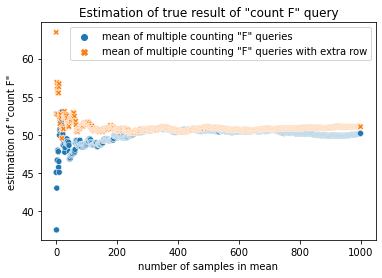

In [6]:
n_means = 1000

counts = [gender_count_private(df, 'F', sensitivity, epsilon) for _ in range(n_means)]
running_mean_counts = [np.mean(counts[:x+1]) for x in range(len(counts)) ]

df_plus_one_row = df.append(pd.DataFrame({'Gender': ['F']}))

counts = [gender_count_private(df_plus_one_row, 'F', sensitivity, epsilon) for _ in range(n_means)]
running_mean_counts_plus_one_row = [np.mean(counts[:x+1]) for x in range(len(counts)) ]


plt.figure()
sns.scatterplot(data=pd.DataFrame({
    'mean of multiple counting "F" queries': running_mean_counts, 
    'mean of multiple counting "F" queries with extra row': running_mean_counts_plus_one_row
}))
plt.title('Estimation of true result of "count F" query')
plt.xlabel('number of samples in mean')
plt.ylabel('estimation of "count F"')

As can be seen above, after the query has been called a number of times on both data frames (which differ by one row), knowledge of the results of the statistic is sufficient to work out which of the two data frames has been used in the statistic; i.e. the differential privacy is no longer private.

This leads to the idea of a "privacy budget", where the budget, as defined by $\epsilon$, only allows so many queries the data. For instance, Apple [3] collect user data (key-logging) using differential privacy, and limit to two queries a day per Apple device.

### Extensions of differential privacy

The definition of $\epsilon$-differential privacy has received extentions in the literature [5]. The purpose of the extensions is typically to allow more queries on the data whilst respecting the privacy budget.

$( \epsilon, \delta )$-differential privacy allows a little more leeway by introducing a small probability $\delta$ 

$\mathbb{P}[\mathcal{K}(D_1)\in S] \leq \exp (\epsilon) \times \mathbb{P}[\mathcal{K}(D_2)\in S] + \delta$

which allows the differential privacy to fail with probability $\delta$. Since smaller databases are more prone to individual identification, one usually works with $\delta < 1/|D|$. The noise mechanism used to generate queries for $( \epsilon, \delta )$-differential privacy is a Gaussian mechanism (which essentially replaces $L_1$ norms in the Laplacian mechanism and sensitivity with $L_2$ norms).

Another variation that is more lax that $\epsilon$ but more strict that $( \epsilon, \delta )$ privacy is Renyi differential privacy [6]. The accounting mechanism offers a tighter bound for privacy loss than $\epsilon$ and $( \epsilon, \delta )$. This is based on the Renyi divergence over pairs of probability distributions

$D_\alpha (P||Q) = \frac{1}{\alpha -1} \log \mathbb{E}_{x\sim Q}\left( \frac{P(x)}{Q(x)} \right)^\alpha$

and a statistic $\mathcal{K}$ is $(\alpha ,\epsilon )$-Renyi differential private if, for all $D_1$, $D_2$ that differ by at most one element,

$D_\alpha( \mathcal{K}(D_1) || \mathcal{K}(D_2) ) \leq \epsilon$.

The divergence is parameterized by $\alpha$, and setting $\alpha$ to $\infty$ yields the $\epsilon$-differential privacy definition. The sensitivity and noise mechanisms are Gaussian.

